# TTT4185 Machine learning for Speech technology

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

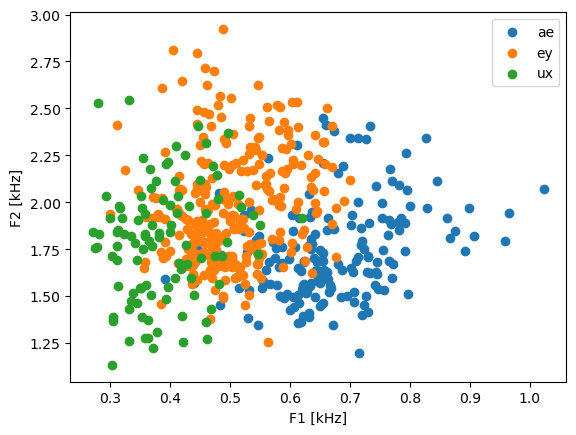

Generally speaking, ae seems to be quite distinguishable from the other vowels because most of its data have both higher F1 and lower F2 than most of the other data. Ey and ux seem to be more mixed, and since ey data generally is located between ae and ux, I think ey will be the hardest to classify.


In [2]:
from cProfile import label
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")


# Extract vowels
aes = train[train["Phoneme"] == "ae"]
eys = train[train["Phoneme"] == "ey"]
uxs = train[train["Phoneme"] == "ux"]

# Plotting here
plt.xlabel("F1 [kHz]")
plt.ylabel("F2 [kHz]")
plt.scatter(aes["F1"], aes["F2"], label="ae")
plt.scatter(eys["F1"], eys["F2"], label="ey")
plt.scatter(uxs["F1"], uxs["F2"], label="ux")
plt.legend()
plt.show()

print("Generally speaking, ae seems to be quite distinguishable from the other vowels because most of its data have both higher F1 and lower F2 than most of the other data. Ey and ux seem to be more mixed, and since ey data generally is located between ae and ux, I think ey will be the hardest to classify.")

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

In [3]:
ae_feature_vector = aes[["F1", "F2"]]
ey_feature_vector = eys[["F1", "F2"]]
ux_feature_vector = uxs[["F1", "F2"]]

feature_vectors = [ae_feature_vector, ey_feature_vector, ux_feature_vector]

total_number_of_training_data_points = len(ae_feature_vector) + len(ey_feature_vector) + len(ux_feature_vector)
parameter_dicts = [
    {
        "mean": feature_vector.mean(),
        "covariance":feature_vector.cov(),
        "prior_probability": len(feature_vector) / total_number_of_training_data_points,
    }
    for feature_vector in feature_vectors
]

for i, phoneme in enumerate(["ae", "ey", "ux"]):
    print(f"{phoneme} parameters:")
    for parameter, value in parameter_dicts[i].items():
        print(f"{parameter}:")
        print(value)
    print()


ae parameters:
mean:
F1    0.66986
F2    1.74238
dtype: float64
covariance:
          F1        F2
F1  0.010608  0.007590
F2  0.007590  0.063172
prior_probability:
0.31115107913669066

ey parameters:
mean:
F1    0.504552
F2    1.978401
dtype: float64
covariance:
          F1        F2
F1  0.006022  0.003870
F2  0.003870  0.087855
prior_probability:
0.5089928057553957

ux parameters:
mean:
F1    0.387384
F2    1.789447
dtype: float64
covariance:
          F1        F2
F1  0.004939  0.003034
F2  0.003034  0.094791
prior_probability:
0.17985611510791366



(c) To visualize the classes models and the classifier created in (b), plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$, by using the following function.

In [4]:
import scipy.stats

def plotGaussian(mean, cov, color, ax):
    """ 
        Creates a contour plot for a bi-variate normal distribution
        
        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = scipy.stats.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    ax.contour(x,y,lik,colors=color)

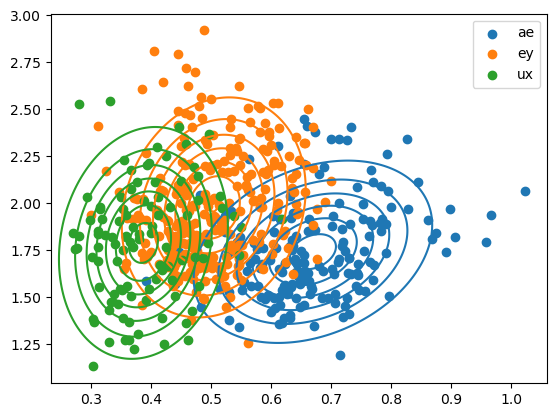

In [5]:
plt.scatter(aes["F1"], aes["F2"], label="ae")
plt.scatter(eys["F1"], eys["F2"], label="ey")
plt.scatter(uxs["F1"], uxs["F2"], label="ux")

for i, phoneme in enumerate(["ae", "ey", "ux"]):
    parameter_dict = parameter_dicts[i]
    plotGaussian(parameter_dict["mean"], parameter_dict["covariance"], list(matplotlib.colors.TABLEAU_COLORS.values())[i], plt.gca())

plt.legend()
plt.show()

*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

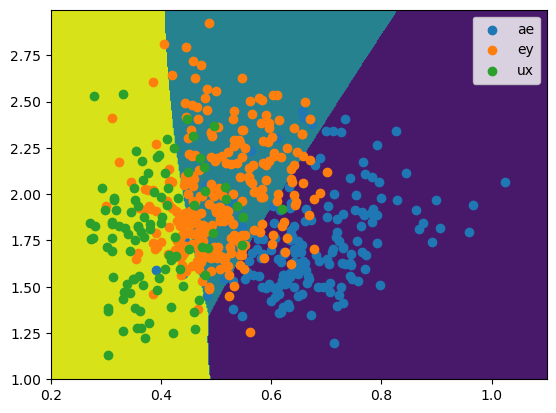

In [6]:
x, y = np.mgrid[0.2:1.1:0.9/500, 1:3:2/500]
xy = np.dstack((x, y))

ae_parameters, ey_parameters, ux_parameters = parameter_dicts

ae_distribution = scipy.stats.multivariate_normal(ae_parameters["mean"], ae_parameters["covariance"])
ey_distribution = scipy.stats.multivariate_normal(ey_parameters["mean"], ey_parameters["covariance"])
ux_distribution = scipy.stats.multivariate_normal(ux_parameters["mean"], ux_parameters["covariance"])

classifier = np.argmax(
    np.dstack([
        ae_distribution.pdf(xy),
        ey_distribution.pdf(xy),
        ux_distribution.pdf(xy),
    ]),
    axis=2,
)

plt.contourf(x, y, classifier)
plt.scatter(aes["F1"], aes["F2"], label="ae")
plt.scatter(eys["F1"], eys["F2"], label="ey")
plt.scatter(uxs["F1"], uxs["F2"], label="ux")
plt.legend()
plt.show()

(d) Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

Test performance: 76.01%
Train performance: 76.80%


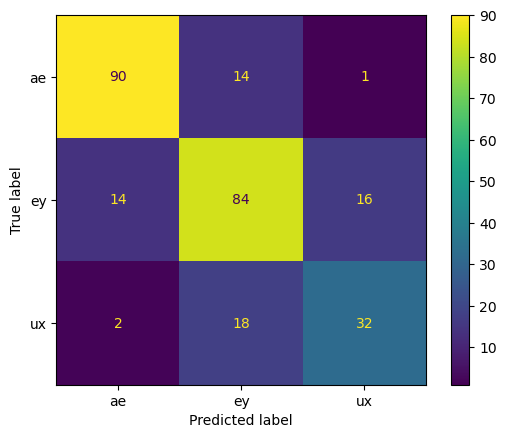

In [122]:
import sklearn.metrics as skm

def generate_confusion_matrix(train_data, test_data, formants):
    classifier = lambda observations: np.argmax(
        np.dstack([
            distribution.pdf(observations)
            for distribution in [
                scipy.stats.multivariate_normal(feature_vector.mean(), feature_vector.cov())
                for feature_vector in [
                    train_data[train_data["Phoneme"] == phoneme][formants]
                    for phoneme in ["ae", "ey", "ux"]
                ]
            ]
        ]),
        axis=2,
    )

    height_level_of_phoneme = np.vectorize(lambda phoneme: ["ae", "ey", "ux"].index(phoneme))
    test_actual = height_level_of_phoneme(test_data[["Phoneme"]].to_numpy())
    test_estimation = classifier(test_data[formants].to_numpy())

    train_actual = height_level_of_phoneme(train_data[["Phoneme"]].to_numpy())
    train_estimation = classifier(train_data[formants].to_numpy())

    test_performance = sum(test_actual == test_estimation.transpose()) / len(test_actual)
    train_performance = sum(train_actual == train_estimation.transpose()) / len(train_actual)

    print(f"Test performance: {test_performance[0]:.2%}")
    print(f"Train performance: {train_performance[0]:.2%}")

    confusion_matrix = skm.confusion_matrix(test_actual, test_estimation.transpose())
    display = skm.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=["ae", "ey", "ux"],
    )
    display.plot()


train_data = train[train["Phoneme"].isin(["ae", "ey", "ux"])]
test_data = test[test["Phoneme"].isin(["ae", "ey", "ux"])]
generate_confusion_matrix(train_data, test_data, ["F1", "F2"])

(e) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (d). Finally use all available information "F1"-"F4" and "B1-B4". How does the performance of this classifier compare with the simpler classifiers using fewer features?

Test performance: 78.23%
Train performance: 77.88%


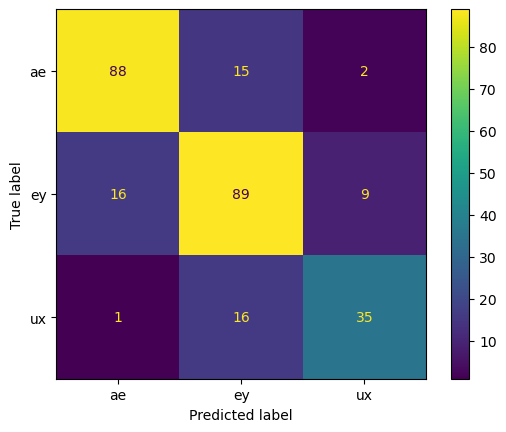

In [123]:
generate_confusion_matrix(train_data, test_data, ["F1", "F2", "F3", "F4"])

(f) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (e).

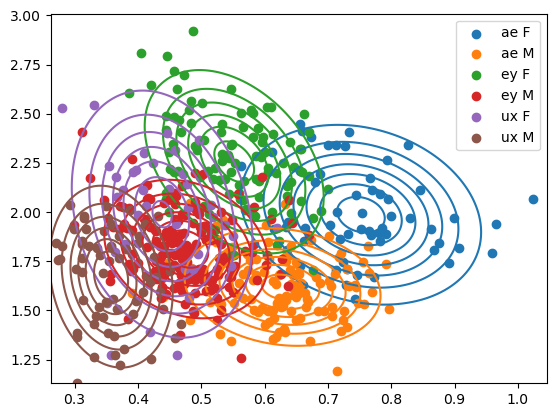

In [190]:
phonemes = ["ae", "ey", "ux"]
genders = ["F", "M"]
formants = ["F1", "F2"]

feature_vectors = np.array(
    [
        [
            train[(train["Phoneme"] == phoneme) & (train["Gender"] == gender)][formants]
            for gender in genders
        ]
        for phoneme in phonemes
    ],
    dtype=object,
)

labels = np.array([
    [f"{phoneme} {gender}" for gender in genders]
    for phoneme in phonemes
])

for i, feature_vector in enumerate(feature_vectors.flatten()):
    plt.scatter(feature_vector["F1"], feature_vector["F2"], label=labels.flatten()[i])
    plotGaussian(feature_vector.mean(), feature_vector.cov(), list(matplotlib.colors.TABLEAU_COLORS.values())[i], plt.gca())

plt.legend()
plt.show()


Test performance: 75.65%
Train performance: 77.52%


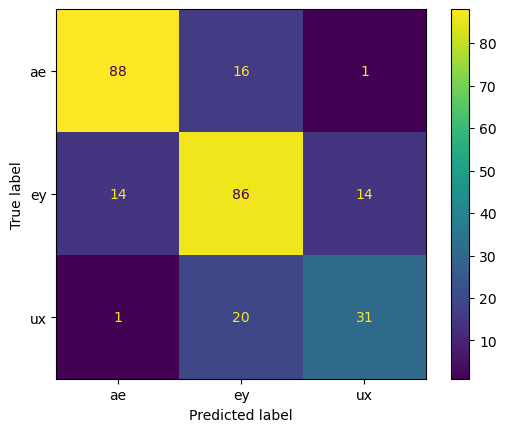

In [191]:
def classifier(observations):
    return np.argmax(
        np.dstack([
            distribution.pdf(observations)
            for distribution in [
                scipy.stats.multivariate_normal(feature_vector.mean(), feature_vector.cov())
                for feature_vector in feature_vectors.flatten()
            ]
        ]),
        axis=2,
    ) // 2

def generate_confusion_matrix_2(train_data, test_data, classifier, formants):
    height_level_of_phoneme = np.vectorize(lambda phoneme: ["ae", "ey", "ux"].index(phoneme))

    test_actual = height_level_of_phoneme(test_data[["Phoneme"]].to_numpy())
    test_estimation = classifier(test_data[formants].to_numpy())

    train_actual = height_level_of_phoneme(train_data[["Phoneme"]].to_numpy())
    train_estimation = classifier(train_data[formants].to_numpy())

    test_performance = sum(test_actual == test_estimation.transpose()) / len(test_actual)
    train_performance = sum(train_actual == train_estimation.transpose()) / len(train_actual)

    print(f"Test performance: {test_performance[0]:.2%}")
    print(f"Train performance: {train_performance[0]:.2%}")

    confusion_matrix = skm.confusion_matrix(test_actual, test_estimation.transpose())
    display = skm.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=phonemes,
    )
    display.plot()

generate_confusion_matrix_2(
    train[train["Phoneme"].isin(phonemes) & train["Gender"].isin(genders)],
    test[test["Phoneme"].isin(phonemes) & test["Gender"].isin(genders)],
    classifier,
    formants,
)

(g) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (f) using only diagonal covariance matrices and compare the results.

Test performance: 73.43%
Train performance: 77.52%


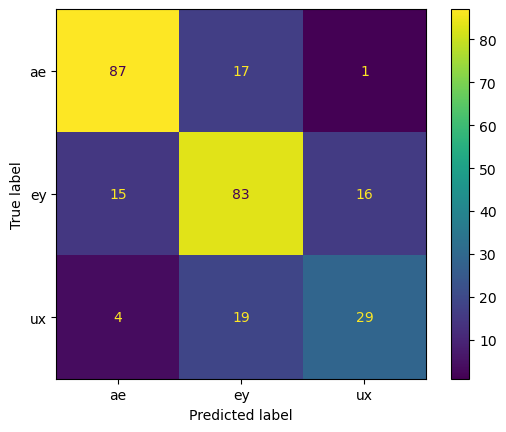

In [193]:
def classifier_diagonal(observations):
    return np.argmax(
        np.dstack([
            distribution.pdf(observations)
            for distribution in [
                scipy.stats.multivariate_normal(feature_vector.mean(), np.diag(np.diag(feature_vector.cov())))
                for feature_vector in feature_vectors.flatten()
            ]
        ]),
        axis=2,
    ) // 2

generate_confusion_matrix_2(
    train[train["Phoneme"].isin(phonemes) & train["Gender"].isin(genders)],
    test[test["Phoneme"].isin(phonemes) & test["Gender"].isin(genders)],
    classifier_diagonal,
    formants,
)

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [61]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

def Plot_SVM_decision_regions(clf,data,labels,axis):
    '''
    This function is for plotting the decision area of SVM
    
    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    phonemes = np.array(["ae","ey","ux"])
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Plotting
    # sns.scatterplot(data[:,0],data[:,1],hue=labels)
    for i, phoneme in enumerate(phonemes):
        phoneme_data = data[labels == i]
        axis.scatter(phoneme_data[:,0],phoneme_data[:,1], label=phoneme)
    axis.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    axis.legend()

def Plot_Support_Vectors(clf,data):
    '''
    This function is for plotting the support vectors of the SVM model
    
    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Support Vectors')
    plt.show()

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

In [64]:
import sklearn.svm

def train_and_plot_svms(*clfs):
    _, axes = plt.subplots(ncols=len(clfs), figsize=(14, 6))
    
    for i, clf in enumerate(clfs):
        ae_features = aes[["F1", "F2"]]
        ey_features = eys[["F1", "F2"]]
        ux_features = uxs[["F1", "F2"]]

        train_x = np.row_stack((
            aes[["F1", "F2"]].to_numpy(),
            eys[["F1", "F2"]].to_numpy(),
            uxs[["F1", "F2"]].to_numpy(),
        ))
        train_y = np.concatenate((
            np.zeros(len(aes)),
            np.ones(len(eys)),
            2 * np.ones(len(uxs)),
        ))

        clf.fit(train_x, train_y)

        test_aes = test[test["Phoneme"] == "ae"]
        test_eys = test[test["Phoneme"] == "ey"]
        test_uxs = test[test["Phoneme"] == "ux"]

        test_x = np.row_stack((
            test_aes[["F1", "F2"]].to_numpy(),
            test_eys[["F1", "F2"]].to_numpy(),
            test_uxs[["F1", "F2"]].to_numpy(),
        ))
        test_y = np.concatenate((
            np.zeros(len(test_aes)),
            np.ones(len(test_eys)),
            2 * np.ones(len(test_uxs)),
        ))

        # clf.predict(test_x)

        Plot_SVM_decision_regions(clf, train_x, train_y, axes[i])
    
    plt.show()


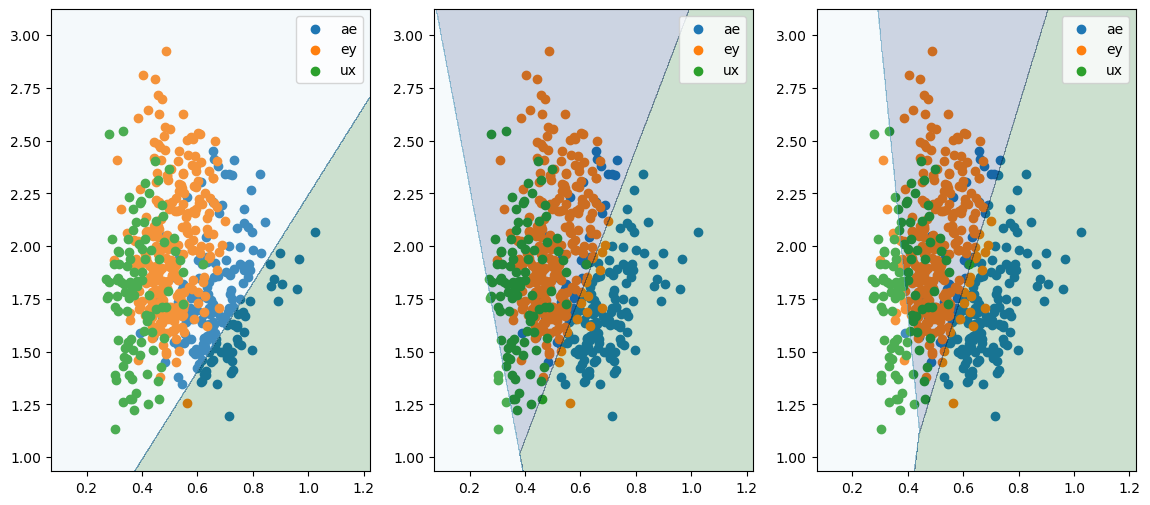

In [67]:
train_and_plot_svms(
    *(
        sklearn.svm.SVC(
            C=C,
            kernel="linear",
        )
        for C in [0.1, 1, 10]
    )
)


(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

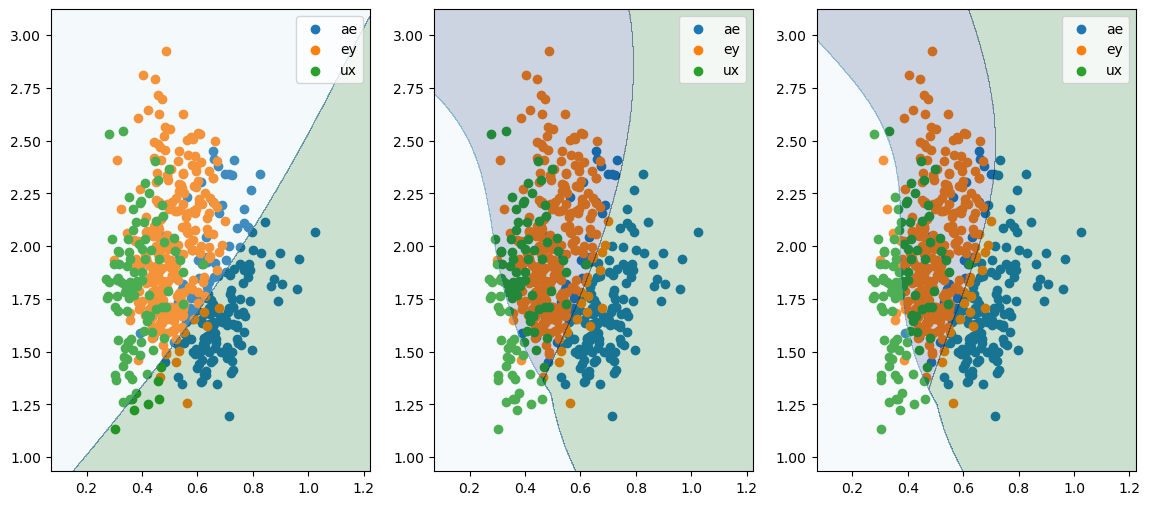

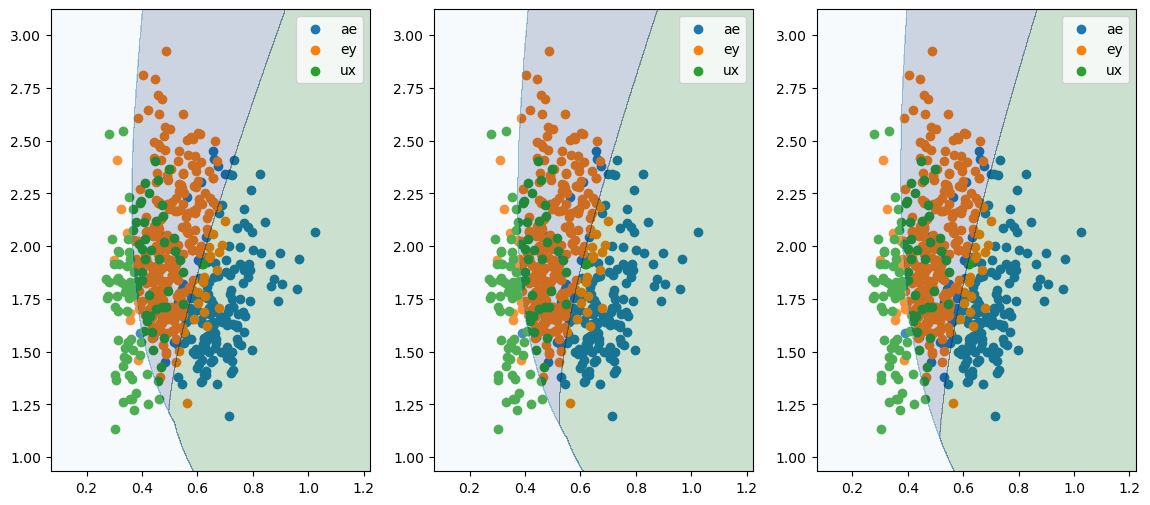

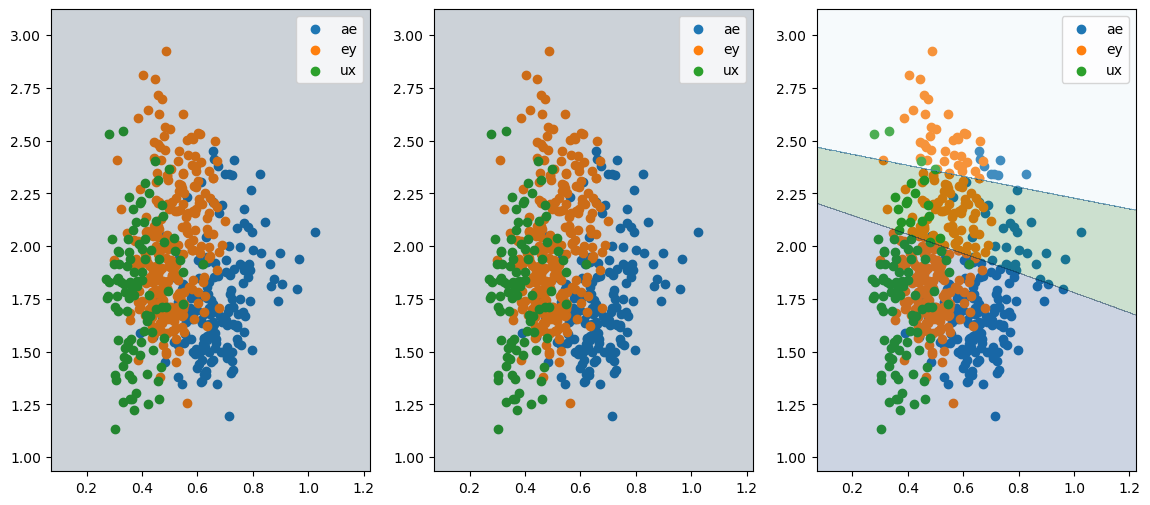

[None, None, None]

In [68]:
[
    train_and_plot_svms(
        *(
            sklearn.svm.SVC(
                C=C,
                kernel=kernel,
            )
            for C in [0.1, 1, 10]
        ),
    )
    for kernel in ["rbf", "poly", "sigmoid"]
]
